In [712]:
import sys
import warnings
import re

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_error,
    d2_tweedie_score,
)
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder

from category_encoders import LeaveOneOutEncoder, TargetEncoder

DATA_PATH = "../data"

In [713]:
# Load excel file
df = pd.read_excel(DATA_PATH + "/consumo_material_clean.xlsx")

## Preprocessing

In [714]:
# Separate code into two columns
new_columns = df["CODIGO"].str.extract(r"([a-zA-Z]+)([0-9]+)", expand=False)
df["CODIGO_CLASS"] = new_columns[0]
df["CODIGO_NUM"] = new_columns[1]
df.drop(columns=["CODIGO"], inplace=True)

In [715]:
# FECHAPEDIDO to datetime in day/month/year format
df["FECHAPEDIDO"] = pd.to_datetime(df["FECHAPEDIDO"], dayfirst=True)
df.sort_values(by=["FECHAPEDIDO"], inplace=True)
df.reset_index(drop=True, inplace=True)

/var/folders/c6/kf2fcpcj6pq_gwpfbfzzy81m0000gn/T/ipykernel_38587/38037239.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["FECHAPEDIDO"] = pd.to_datetime(df["FECHAPEDIDO"], dayfirst=True)


In [716]:
# separate ORIGEN in three columns by '-'
origin_separated_columns = df["ORIGEN"].str.split("-", expand=True)
df["PURCHASING_HOSPITAL"] = origin_separated_columns[1]
df["PURCHASING_DEPARTMENT"] = origin_separated_columns[2]
df.drop(columns=["ORIGEN"], inplace=True)

In [717]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [718]:
# dictionary CODIGO_NUM to PRECIO
product_num_to_price_per_unit = (
    df.groupby("CODIGO_NUM")["PRECIO"].max()
    / df.groupby("CODIGO_NUM")["UNIDADESCONSUMOCONTENIDAS"].max()
).to_dict()

In [719]:
# basic date features
def generate_date_features(df):
    df["YEAR"] = df["FECHAPEDIDO"].dt.year
    df["MONTH"] = np.sin(2 * np.pi * df["FECHAPEDIDO"].dt.month / 12)
    df["DAYOFMONTH"] = np.sin(2 * np.pi * df["FECHAPEDIDO"].dt.day / 31)
    df["DAYOFYEAR"] = np.sin(2 * np.pi * df["FECHAPEDIDO"].dt.dayofyear / 365)
    return df

In [720]:
def add_timeseries_features(df):
    # MEANS
    df["ROLLING_MEAN_3M"] = df["CANTIDADCOMPRA"].rolling(90).mean()
    df["ROLLING_MEAN_1Y"] = df["CANTIDADCOMPRA"].rolling(365).mean()

    # WEIGHTED MEANS
    df["WEIGHTED_MEAN_3M"] = (
        df["CANTIDADCOMPRA"]
        .rolling(90)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )
    df["WEIGHTED_MEAN_1Y"] = (
        df["CANTIDADCOMPRA"]
        .rolling(365)
        .apply(lambda x: np.average(x, weights=range(1, len(x) + 1)))
    )

    # EXPONENTIAL WEIGHTED MEANS
    df["EWMA_1W"] = df["CANTIDADCOMPRA"].ewm(span=7).mean()
    df["EWMA_1M"] = df["CANTIDADCOMPRA"].ewm(span=30).mean()
    df["EWMA_3M"] = df["CANTIDADCOMPRA"].ewm(span=90).mean()
    df["EWMA_1Y"] = df["CANTIDADCOMPRA"].ewm(span=365).mean()

    # LAGS
    df["SHIFT_1W"] = df["CANTIDADCOMPRA"].shift(7)
    df["SHIFT_1M"] = df["CANTIDADCOMPRA"].shift(30)
    df["SHIFT_3M"] = df["CANTIDADCOMPRA"].shift(90)
    df["SHIFT_1Y"] = df["CANTIDADCOMPRA"].shift(365)

    # DIFFS
    df["DIFF_1W"] = df["CANTIDADCOMPRA"].diff(7)
    df["DIFF_1M"] = df["CANTIDADCOMPRA"].diff(30)
    df["DIFF_3M"] = df["CANTIDADCOMPRA"].diff(90)
    df["DIFF_1Y"] = df["CANTIDADCOMPRA"].diff(365)

    return df

In [721]:
def generate_train_test_df(full_df):
    # Get train and test sets
    train = full_df[full_df["YEAR"] < 2023]
    X_train = train.drop(columns=["CANTIDADCOMPRA", "FECHAPEDIDO"])
    y_train = train["CANTIDADCOMPRA"]

    test = full_df[full_df["YEAR"] == 2023]
    X_test = test.drop(columns=["CANTIDADCOMPRA", "FECHAPEDIDO"])
    y_test = test["CANTIDADCOMPRA"]

    return train, X_train, y_train, test, X_test, y_test

In [722]:
def smape_score(A, F):
    return 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [723]:
def train_model_eval(X_train, y_train, X_test, y_test, product):
    model_list = [
        LGBMRegressor(random_state=42, n_estimators=1000, verbose=-1),
        XGBRegressor(random_state=42, n_estimators=1000),
    ]
    preds = []

    for model in model_list:
        model.fit(X_train, y_train)
        y_test_par_pred = model.predict(X_test)
        y_test_par_pred = np.maximum(y_test_par_pred, 0)
        preds.append(y_test_par_pred)

    y_test_pred = np.mean(preds, axis=0)

    # LOSSES
    test_loss = mean_squared_error(y_test, y_test_pred, squared=False)
    mape_error = mean_absolute_percentage_error(y_test, y_test_pred)
    tweedie = d2_tweedie_score(y_test, y_test_pred)
    smape_err = smape_score(y_test, y_test_pred)

    forecasted_expenses = y_test_pred.sum() * product_num_to_price_per_unit[product]
    real_expenses = y_test.sum() * product_num_to_price_per_unit[product]
    mape_expenses = np.abs(forecasted_expenses - real_expenses) / real_expenses

    return_test_preds = pd.concat([X_test, y_test], axis=1)
    return return_test_preds, test_loss, mape_error, smape_err, tweedie, mape_expenses

In [724]:
def plot_model_predictions(full_df, product, plot_train=False, plot_importances=False):
    columns = [
        "FECHAPEDIDO",
        "CANTIDADCOMPRA",
        "PURCHASING_HOSPITAL",
        "PURCHASING_DEPARTMENT",
    ]
    partial_df = full_df[full_df["CODIGO_NUM"] == product]
    partial_df = partial_df.groupby(columns).sum().reset_index()

    loo = LeaveOneOutEncoder()
    partial_df["PURCHASING_HOSPITAL"] = loo.fit_transform(
        partial_df["PURCHASING_HOSPITAL"], partial_df["CANTIDADCOMPRA"]
    )

    loo = TargetEncoder()
    partial_df["PURCHASING_DEPARTMENT"] = loo.fit_transform(
        partial_df["PURCHASING_DEPARTMENT"], partial_df["CANTIDADCOMPRA"]
    )

    partial_df = partial_df[columns]
    partial_df = generate_date_features(partial_df)
    partial_df = add_timeseries_features(partial_df)
    train, X_train, y_train, test, X_test, y_test = generate_train_test_df(partial_df)
    feature_importance_plot_columns = X_train.columns

    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)

    X_train["PREDICTION"] = np.maximum(model.predict(X_train), 0)
    X_train["REAL"] = y_train
    X_train["FECHAPEDIDO"] = train["FECHAPEDIDO"]

    X_test["PREDICTION"] = np.maximum(model.predict(X_test), 0)
    X_test["REAL"] = y_test
    X_test["FECHAPEDIDO"] = test["FECHAPEDIDO"]

    plt.figure(figsize=(20, 10))
    if plot_train:
        sns.lineplot(
            x="FECHAPEDIDO",
            y="PREDICTION",
            data=X_train,
            marker="o",
            label="train preds",
        )
        sns.lineplot(
            x="FECHAPEDIDO", y="REAL", data=X_train, marker="o", label="train real"
        )

    sns.lineplot(
        x="FECHAPEDIDO",
        y="PREDICTION",
        data=X_test,
        marker="o",
        label="test preds",
        ci=None,
    )
    sns.lineplot(
        x="FECHAPEDIDO", y="REAL", data=X_test, marker="o", label="test real", ci=None
    )

    plt.legend()
    plt.title(f"Product: {product}")
    plt.show()

    if plot_importances:
        model_importances = pd.DataFrame(
            {
                "feature": feature_importance_plot_columns,
                "importance": model.feature_importances_,
            }
        )
        model_importances.sort_values(by=["importance"], ascending=False, inplace=True)
        model_importances.reset_index(drop=True, inplace=True)
        plt.figure(figsize=(10, 10))
        sns.barplot(x="importance", y="feature", data=model_importances)
        plt.show()

In [725]:
%%time

columns = ["FECHAPEDIDO", "CANTIDADCOMPRA", "PURCHASING_HOSPITAL", "PURCHASING_DEPARTMENT"]

product_losses = pd.DataFrame(columns=["PRODUCT", "Tweedie", "MSE", "SMAPE", "EXPENSE_ERROR"])
for product in df["CODIGO_NUM"].unique():
    partial_df = df[df["CODIGO_NUM"] == product]
    partial_df = partial_df.groupby(columns).sum().reset_index()

    loo = LeaveOneOutEncoder()
    partial_df["PURCHASING_HOSPITAL"] = loo.fit_transform(
        partial_df["PURCHASING_HOSPITAL"], partial_df["CANTIDADCOMPRA"]
    )

    loo = TargetEncoder()
    partial_df["PURCHASING_DEPARTMENT"] = loo.fit_transform(
        partial_df["PURCHASING_DEPARTMENT"], partial_df["CANTIDADCOMPRA"]
    )

    partial_df = partial_df[columns]
    partial_df = generate_date_features(partial_df)
    partial_df = add_timeseries_features(partial_df)

    is_2023_in_df = 2023 in partial_df["YEAR"].unique()
    product_blacklist = ["85758", "73753", "65007", "66071", "64544"] # stops selling in 2023
    if not is_2023_in_df or product in product_blacklist:
        continue

    train, X_train, y_train, test, X_test, y_test = generate_train_test_df(
        partial_df
    )
    y_test_preds, test_loss, mape_error, smape, tweedie, mae_expenses = train_model_eval(X_train, y_train, X_test, y_test, product)

    product_losses = pd.concat(
        [
            product_losses,
            pd.DataFrame(
                [[product, tweedie, test_loss, smape, mae_expenses]],
                columns=["PRODUCT", "Tweedie", "MSE", "SMAPE", "EXPENSE_ERROR"],
            ),
        ]
    )

CPU times: user 1min 2s, sys: 1min 41s, total: 2min 43s
Wall time: 1min 16s


In [726]:
product_losses.sort_values(by=["EXPENSE_ERROR"], ascending=False).head()

,PRODUCT,Tweedie,MSE,SMAPE,EXPENSE_ERROR
0,65056,0.495367,335.460856,42.875289,0.302234
0,65485,0.655914,102.767035,23.079493,0.228691
0,64764,0.380909,926.625603,29.730300,0.227269
0,69682,0.447645,37.896223,16.520367,0.181765
0,50071,0.255108,4.305755,21.626226,0.173299


In [727]:
final_smape = product_losses["SMAPE"].mean()
final_mse = product_losses["MSE"].mean()
final_tweedie = product_losses[product_losses["Tweedie"] != -np.inf]["Tweedie"].mean()
final_expense_mape = product_losses["EXPENSE_ERROR"].mean()

print("SMAPE: ", final_smape)
print("MSE: ", final_mse)
print("Tweedie: ", final_tweedie)
print("Expense MAPE: ", final_expense_mape)

SMAPE:  16.89393295852728
MSE:  102.2692452625142
Tweedie:  0.7089493713195335
Expense MAPE:  0.07146466019401258


## Sample product prediction: Boltzmann Ensemble

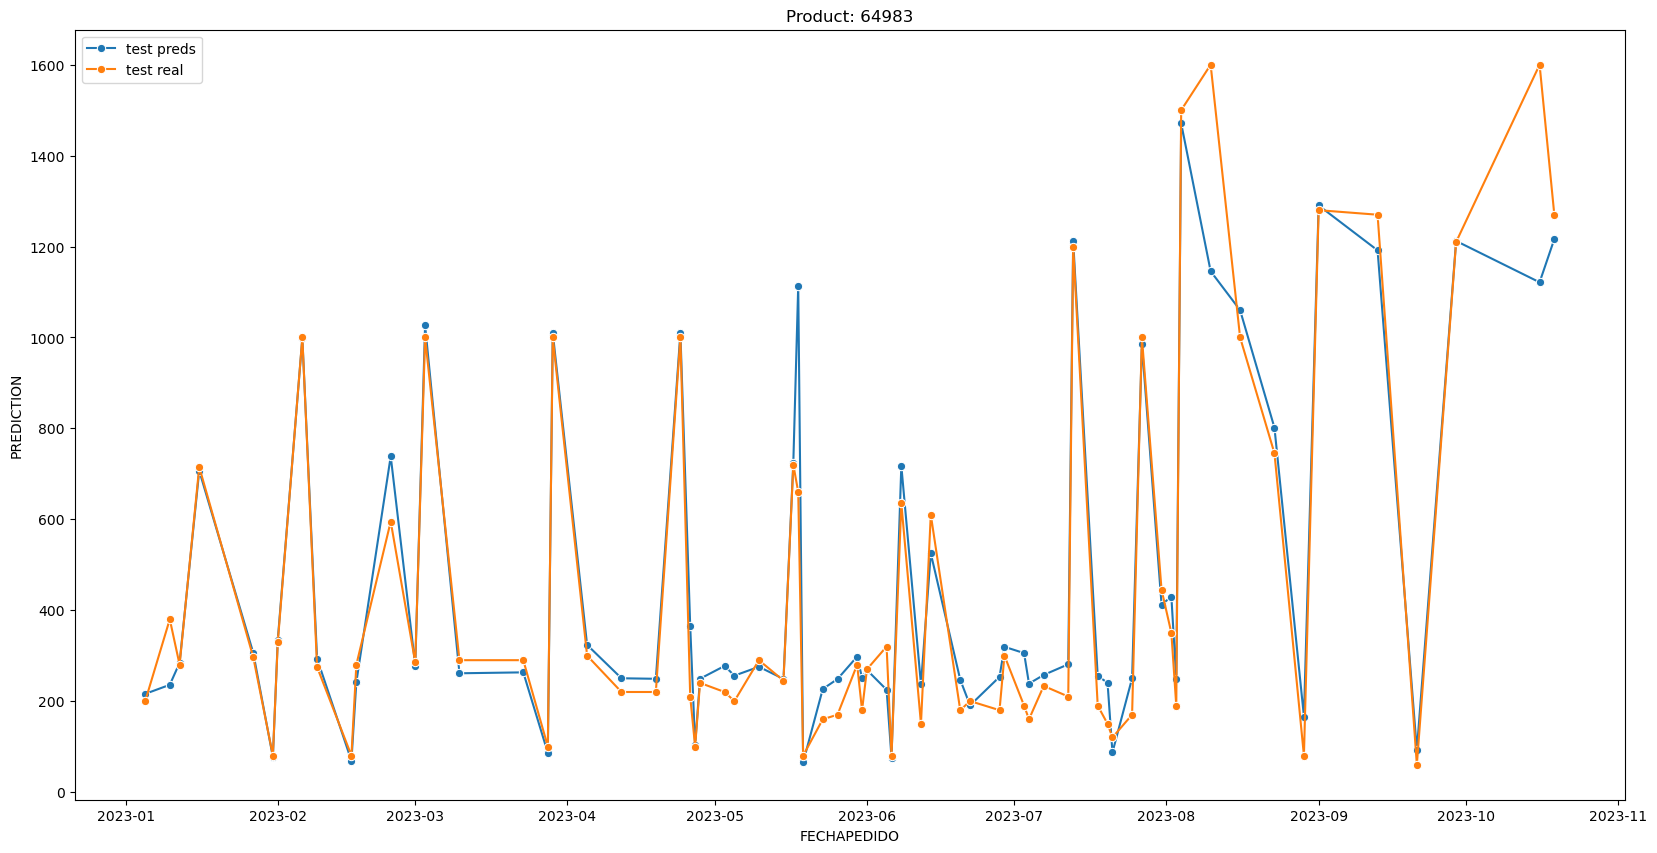

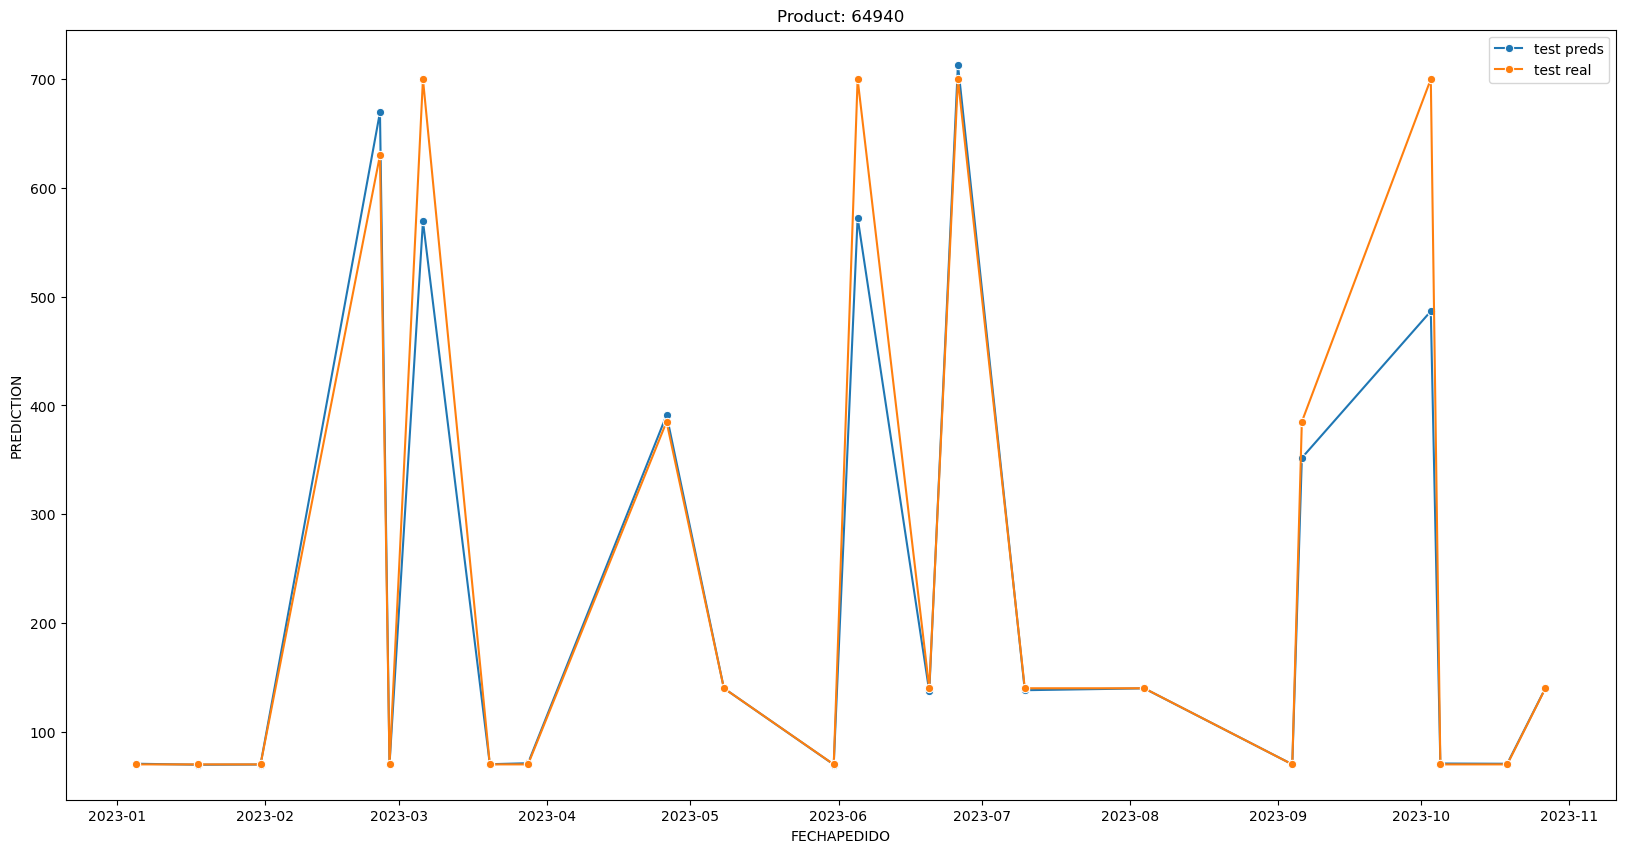

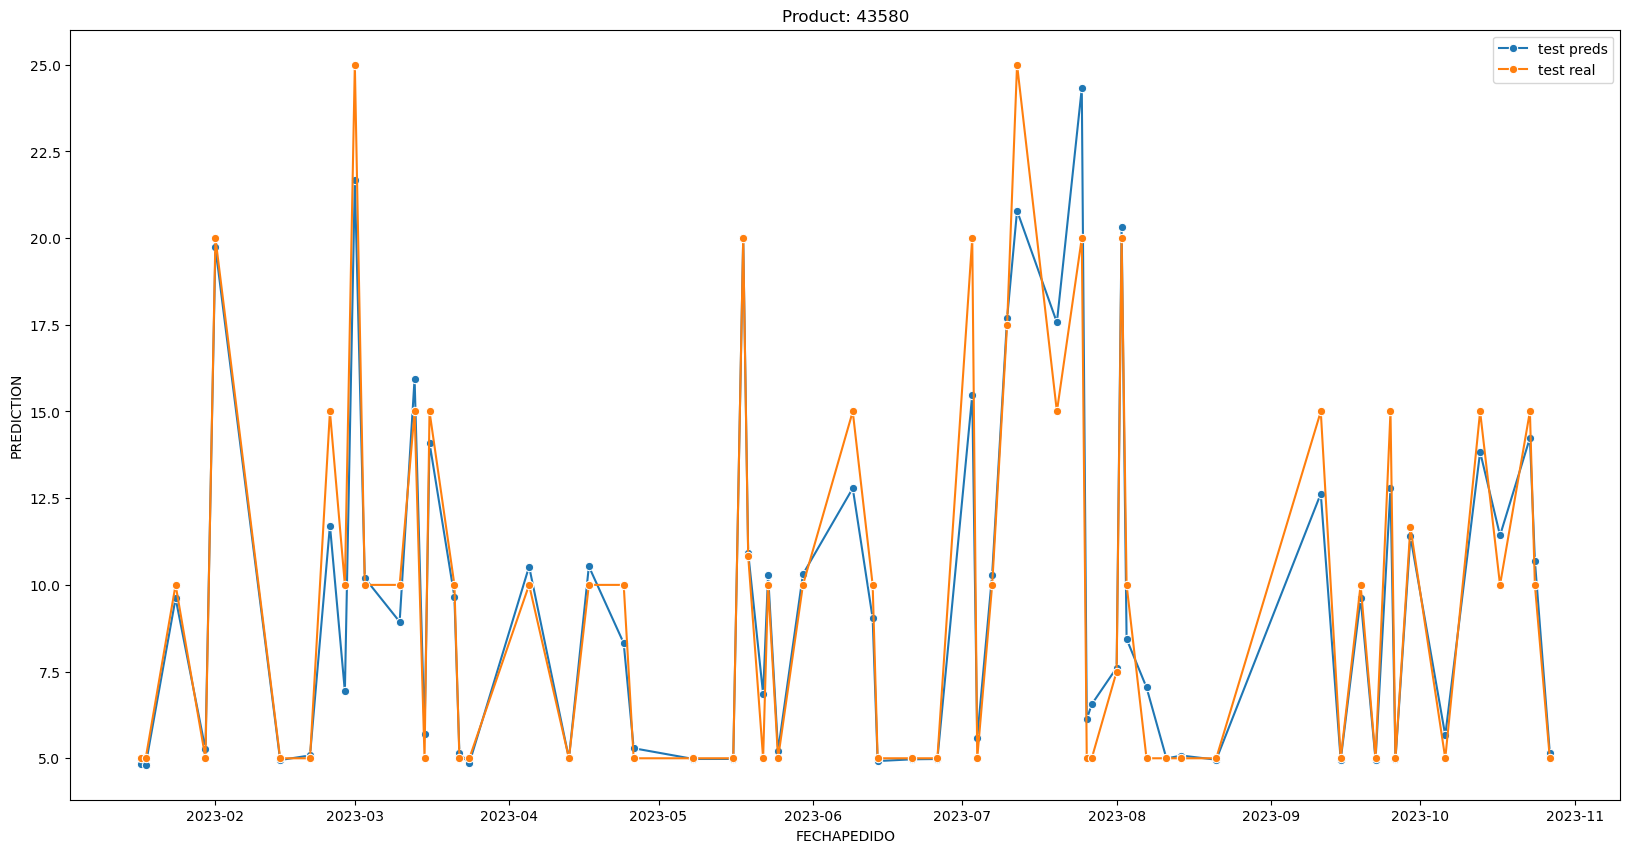

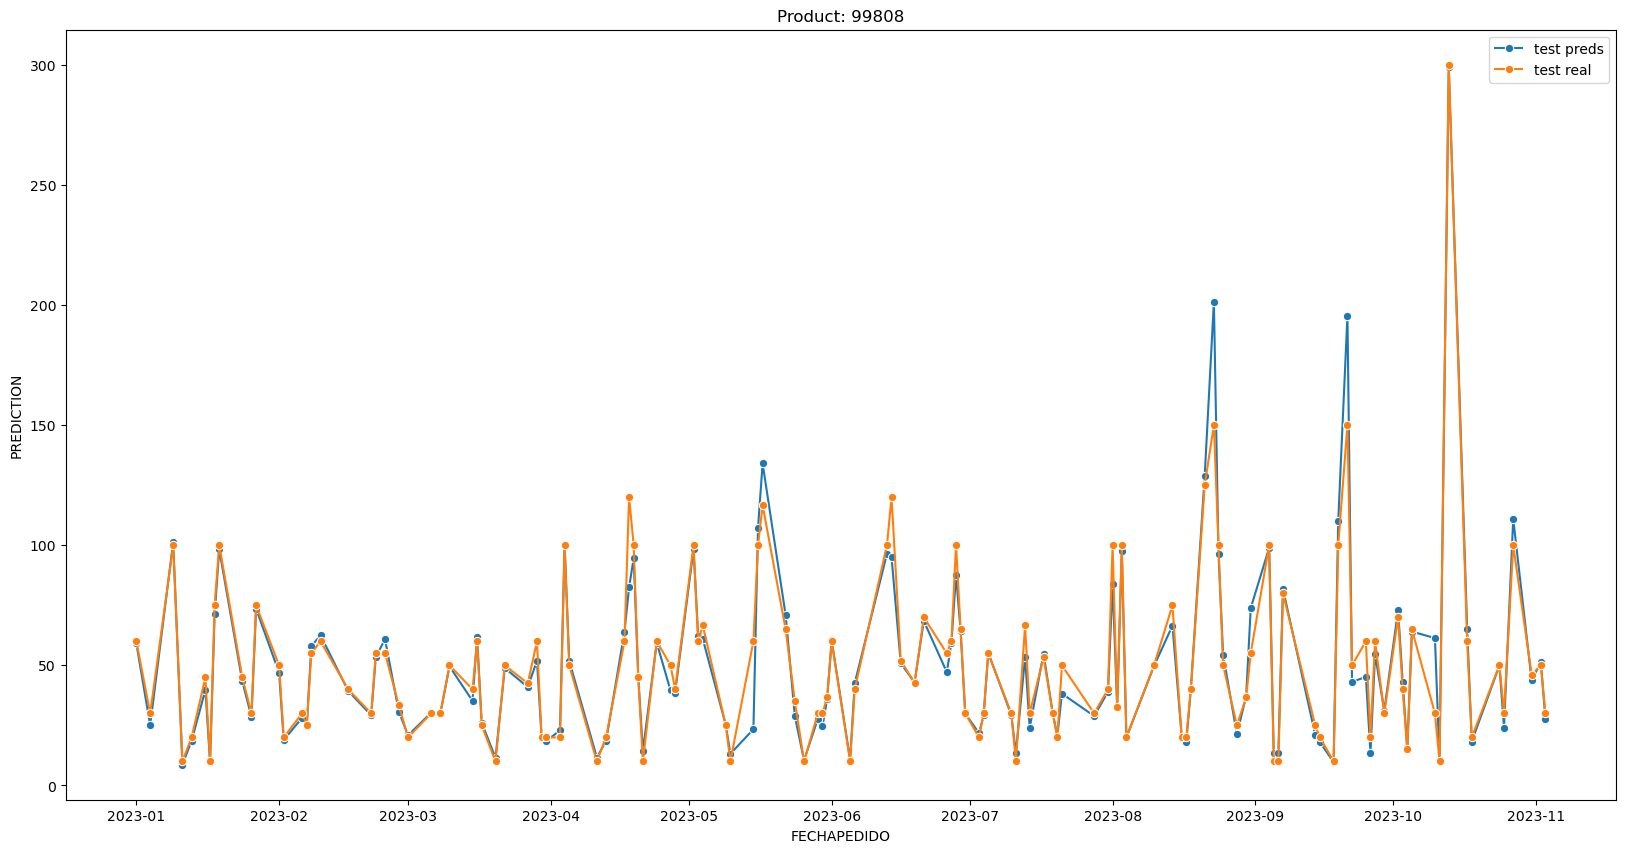

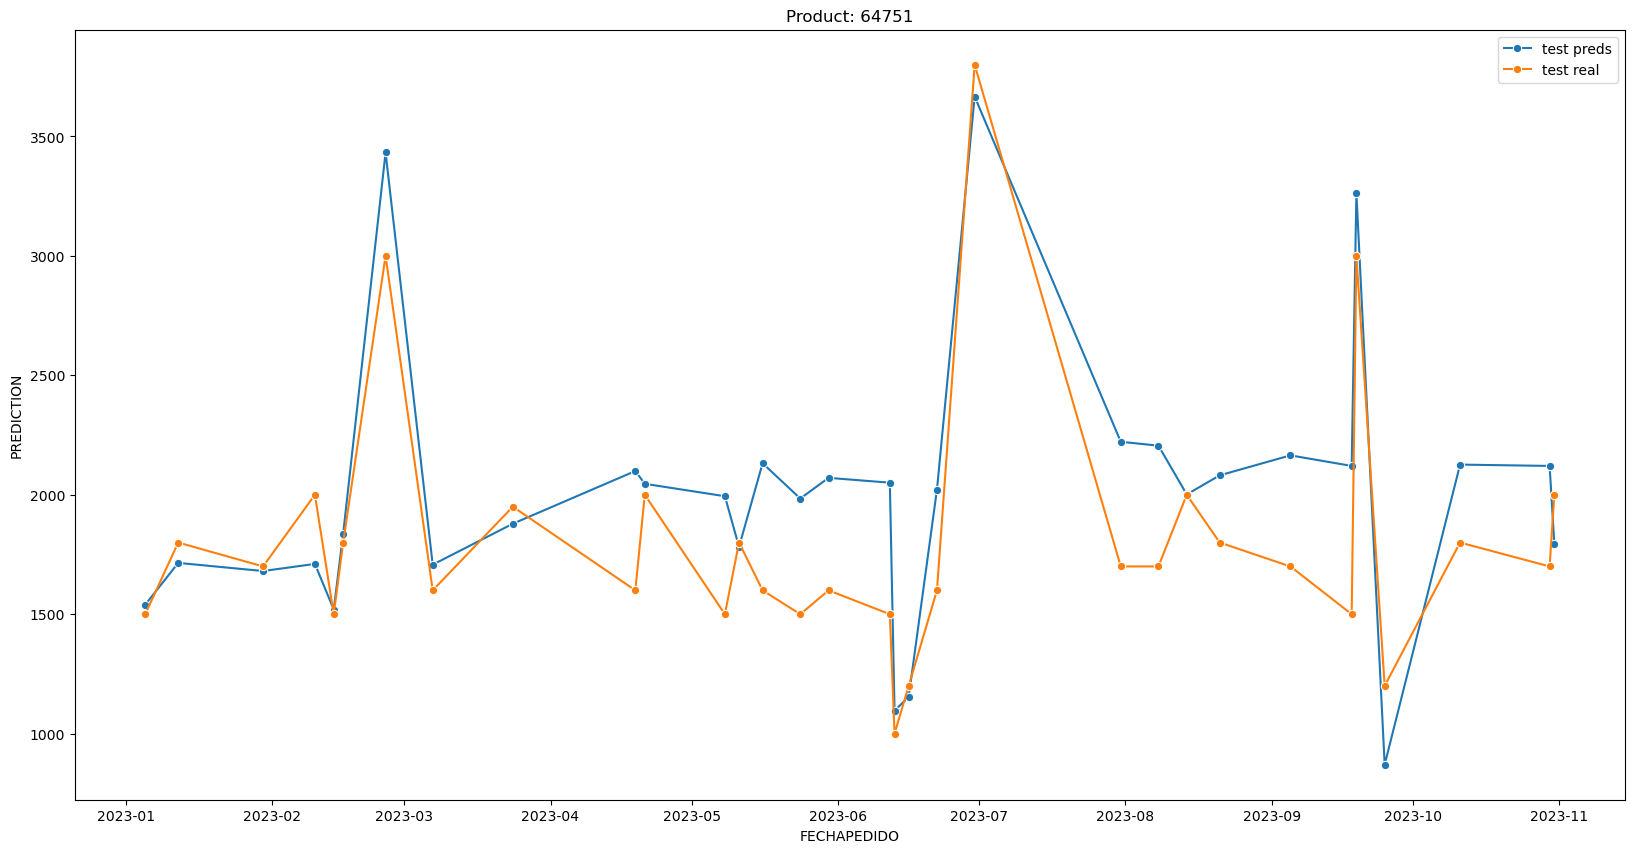

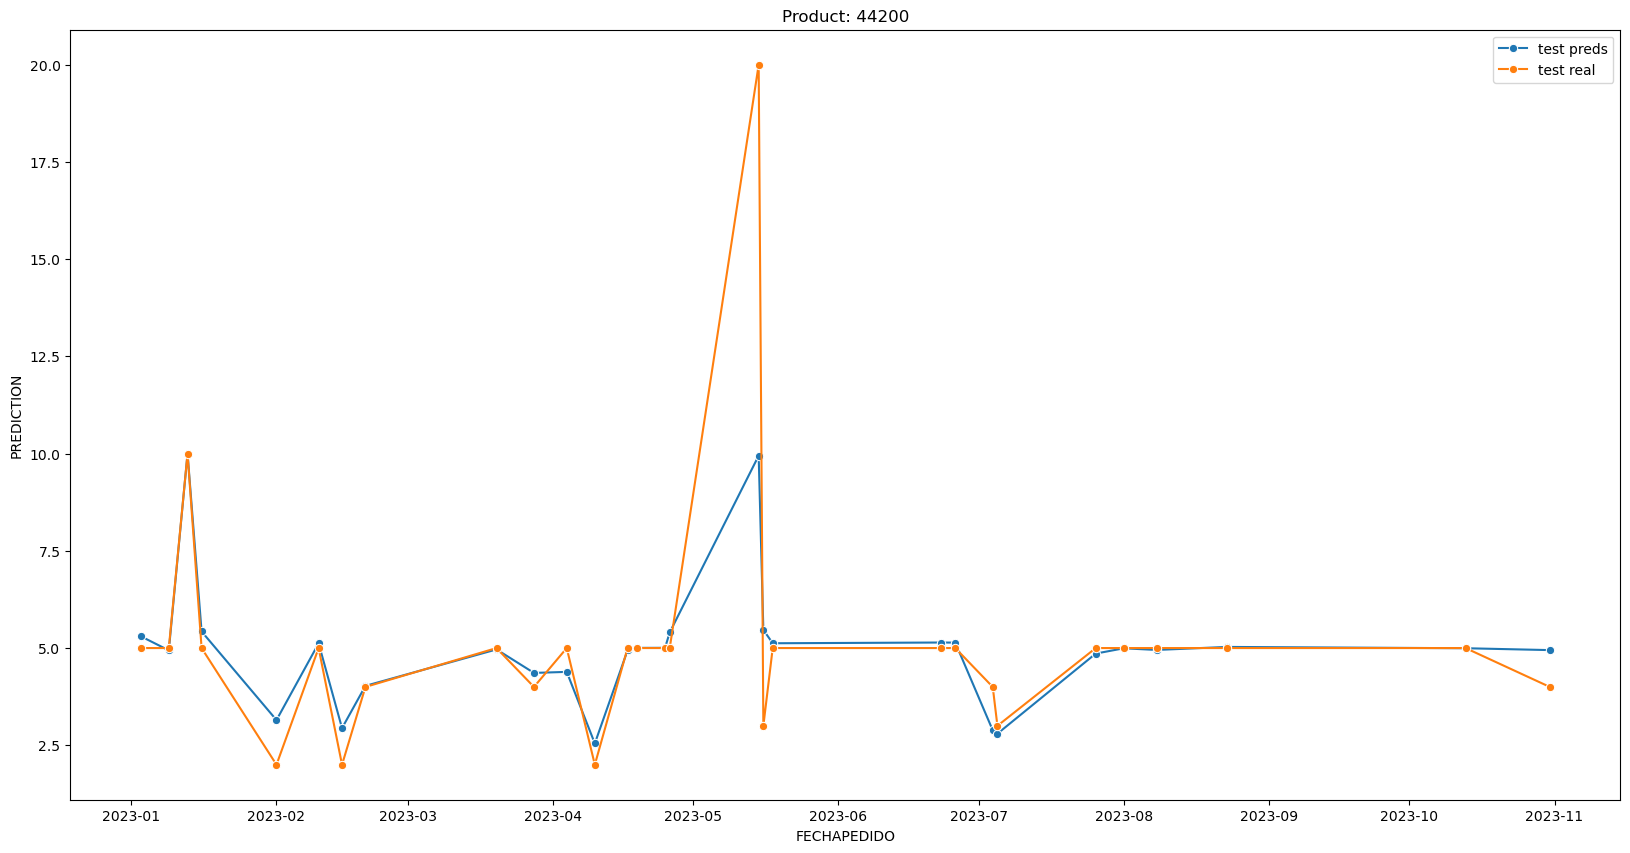

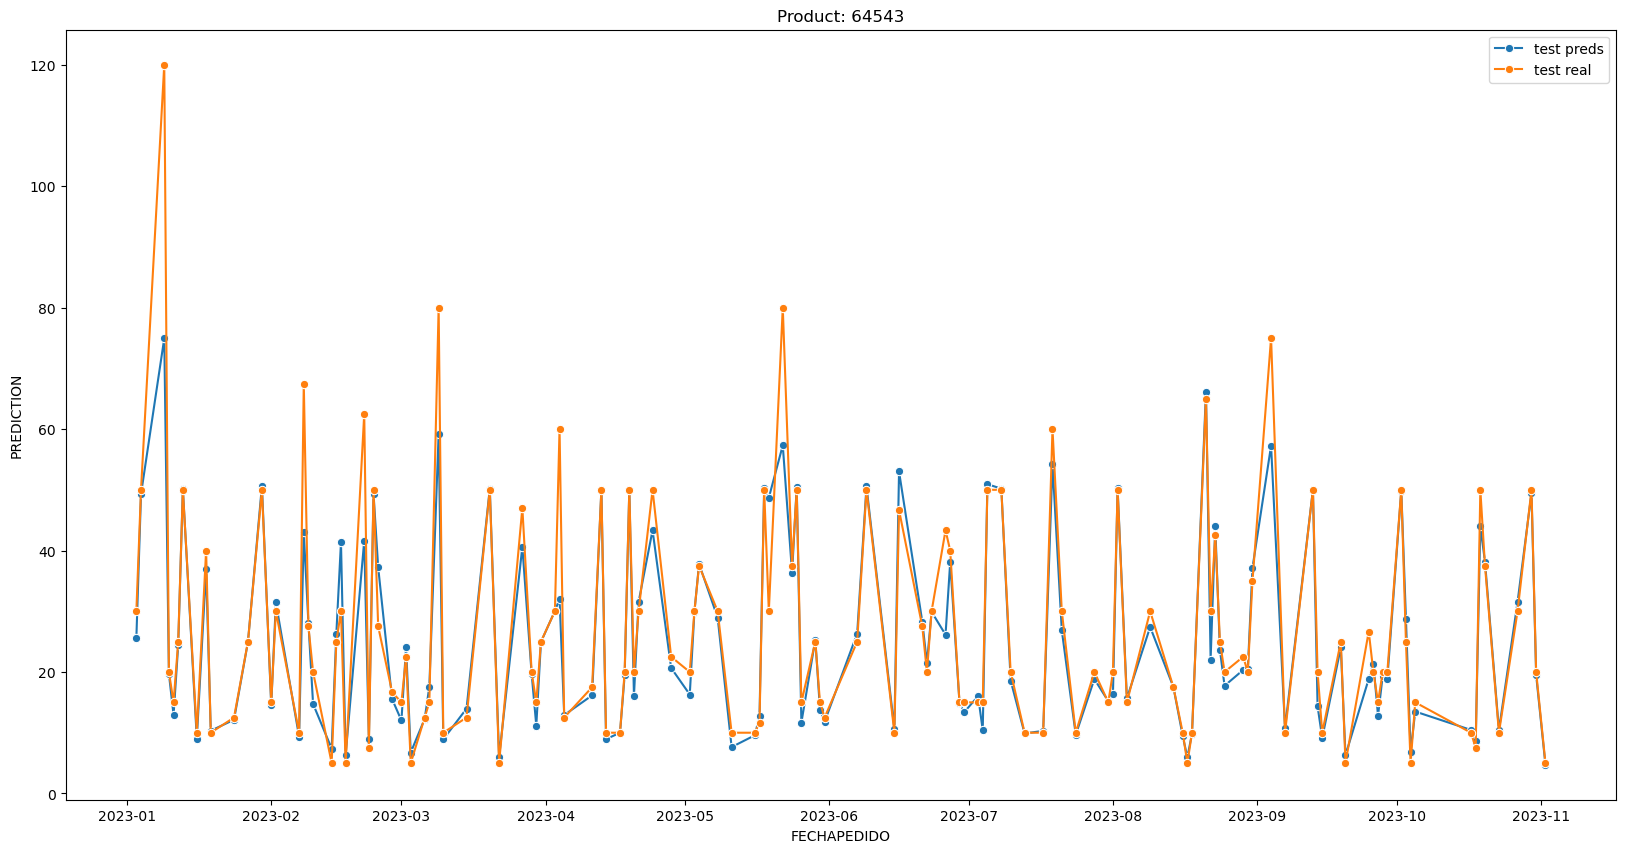

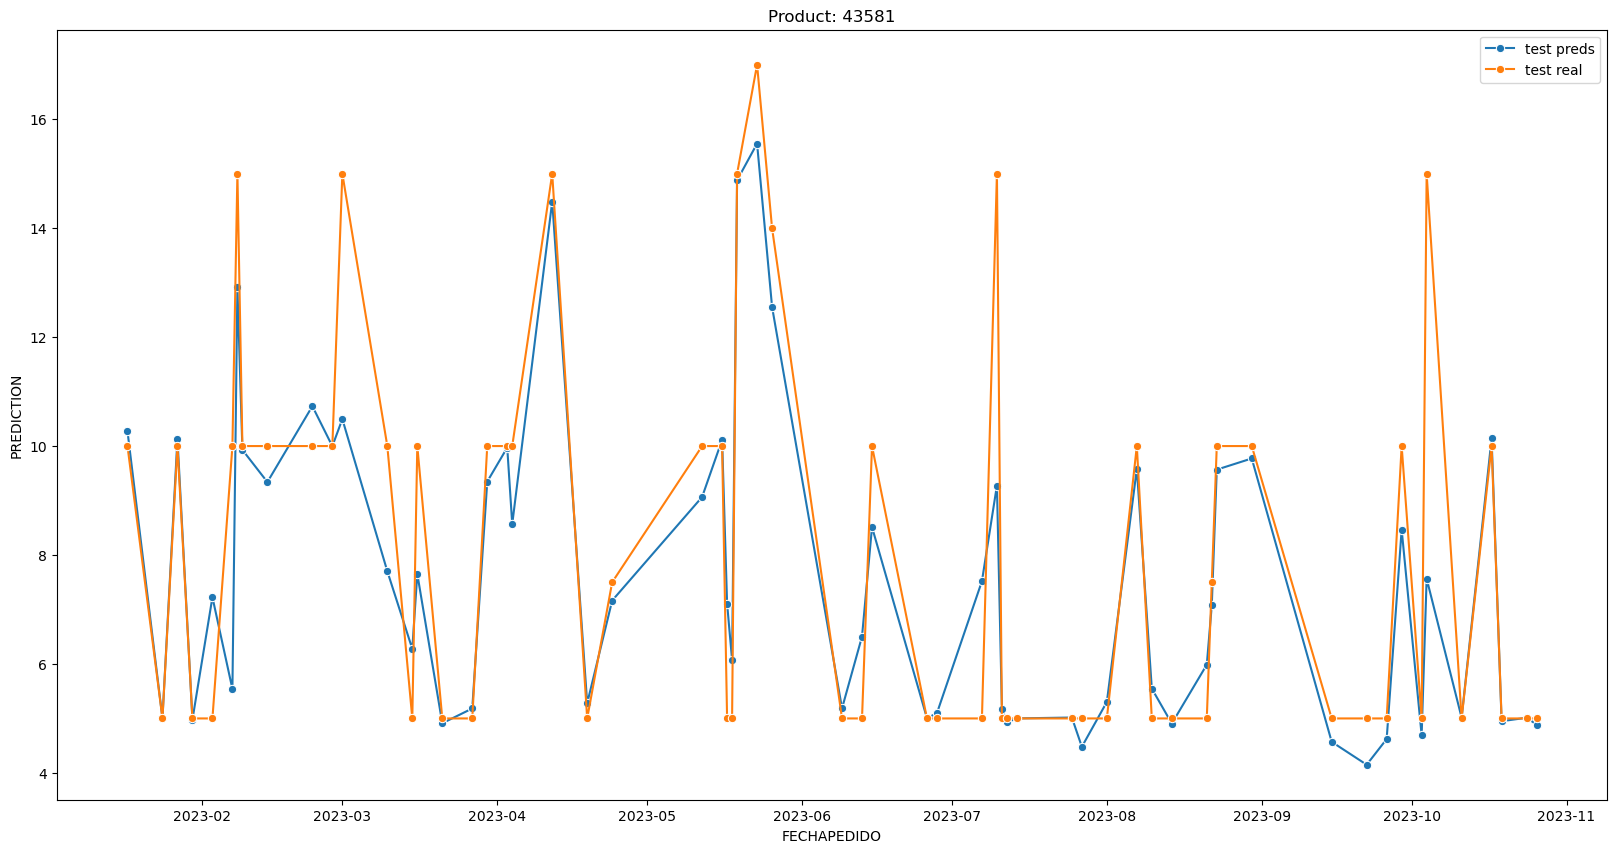

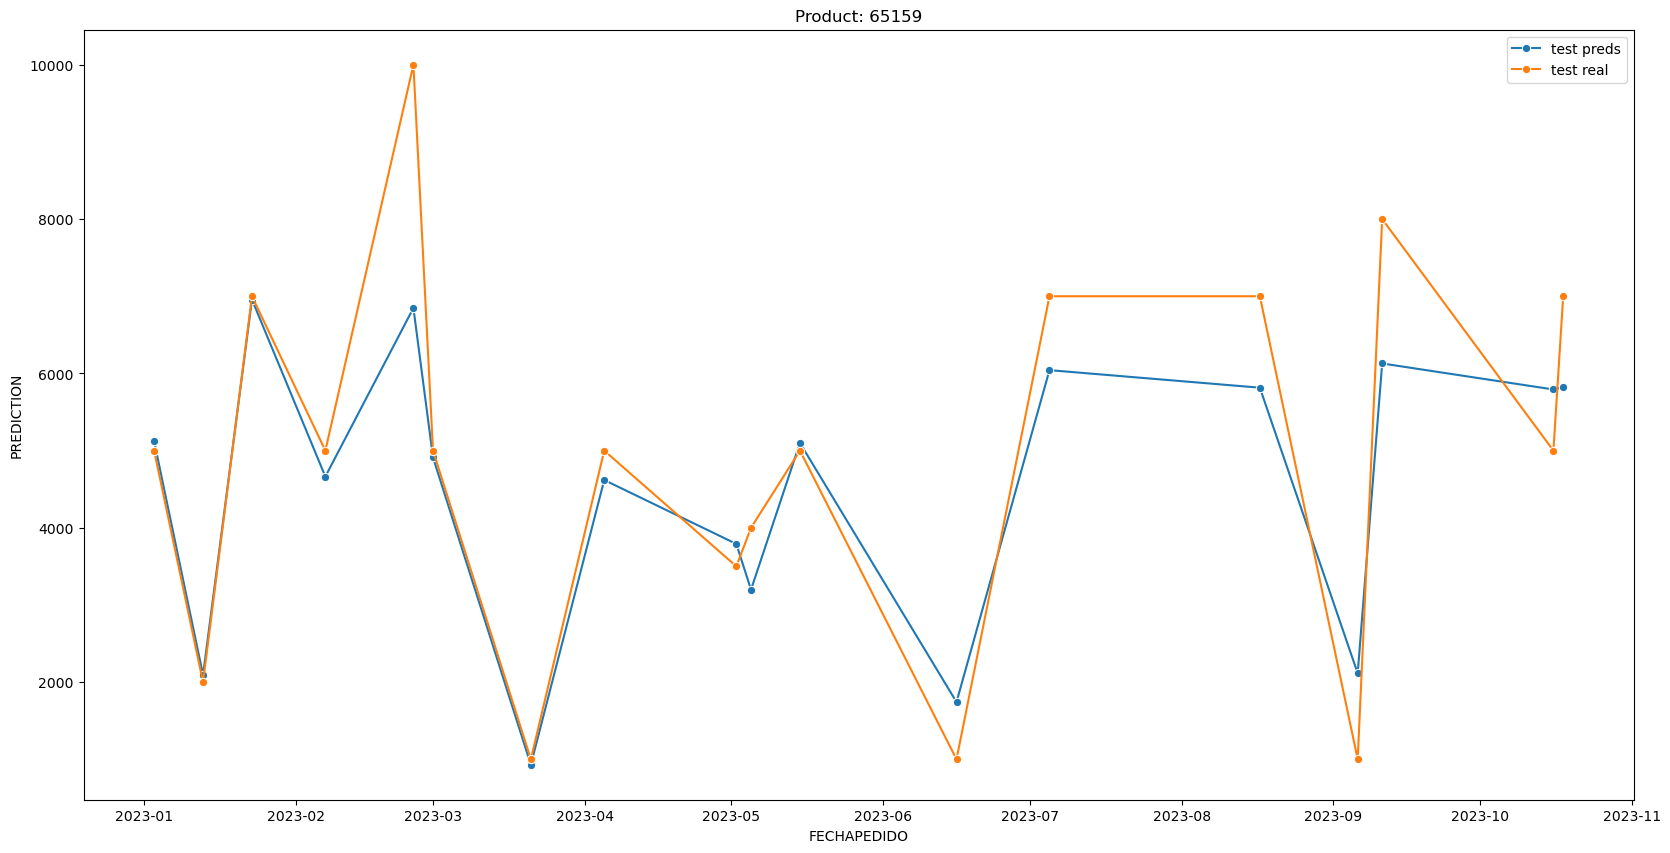

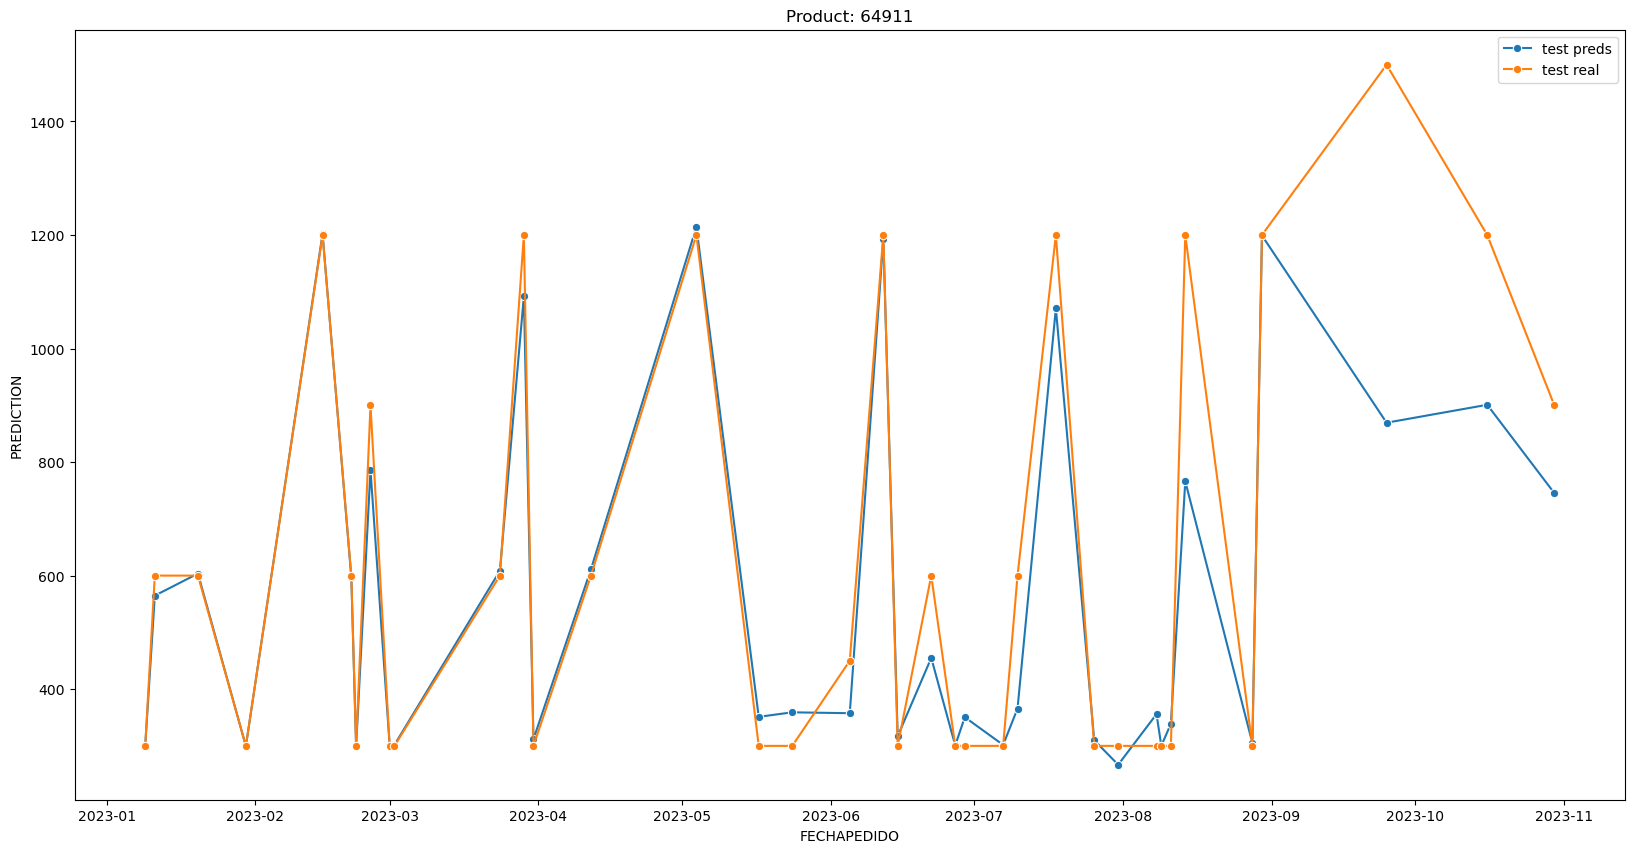

In [728]:
for product in product_losses.sort_values(by=["Tweedie"], ascending=False)[
    "PRODUCT"
].head(10):
    plot_model_predictions(full_df=df, product=str(product))